In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

Using TensorFlow backend.


In [2]:
# This function lists out all permutations of ace values in the array sum_array
# For example, if you have 2 aces, there are 4 permutations:
#     [[1,1], [1,11], [11,1], [11,11]]
# These permutations lead to 3 unique sums: [2, 12, 22]
# Of these 3, only 2 are <=21 so they are returned: [2, 12]
def get_ace_values(ace_list):
    sum_array = np.zeros((2*len(ace_list), len(ace_list)))
    # This loop gets the permutations
    for i in range(len(ace_list)):
        n = len(ace_list) - i
        half_len = int(2 ** n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)):
            sum_array[rep *2**n: rep * 2**n + half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # return values that are valid (<=21)
    return list(set([int(s) for s in np.sum(sum_array, axis=1) if s<=21]))

# Convert num_aces, an int to a list of lists
# For example if num_aces=2, the output should be [[1,11],[1,11]]
def ace_values(num_aces):
    ace_list = []
    for i in range(num_aces):
        ace_list.append([1,11])
    return get_ace_values(ace_list)

In [3]:
# generate a deck
# card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]
def generate_decks(num_decks, card_types):
    deck = []
    for i in range(num_decks):
        for j in range(4):
            deck.extend(card_types)
    random.shuffle(deck)
    return deck

In [4]:
# sum up value of hand card
def sum_up(hand):
    num_aces = 0 #num of aces
    total = 0  #total score
    for card in hand:
        if card != 'A':
            total += card  #if the card is not 'A', get the face value
        else:
            num_aces += 1  #how many aces does the hand card have
    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(num_aces) #get ace value from this hand of aces
    final_totals = [i+total for i in ace_value_list if i+total<=21]  # total score in the hand
    
    if final_totals == []:
        if ace_value_list == []:
            return total
        else:
            return min(ace_value_list) + total
    else:
        return max(final_totals)

In [5]:
# Play a game of blackjack (after the cards are dealt)
# blackjack = set(['A',10])
#1 check dealer_card == blackjack? yes, check player blackjack? player blackjack yes(0) no(player -1)
#2 check player blackjack? yes player win
def play_game(dealer_hand, player_hands, blackjack, curr_player_results, dealer_cards, hit_stand):
    action = 0
    # Dealer checks for 21
    if set(dealer_hand) == blackjack:
        for player in range(players):
            if set(player_hands[player]) != blackjack:
                curr_player_results[0,player] = -1 #player lose
            else:
                curr_player_results[0,player] = 0 # both have blackjack 
    else:
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack:
                curr_player_results[0,player] = 1  #player lose
            else:
                # Hit randomly, check for busts
                if (hit_stand >= 0.5) and (sum_up(player_hands[player]) != 21):
                    player_hands[player].append(dealer_cards.pop(0))  #player get one more card
                    action = 1  #hit
                    live_total.append(sum_up(player_hands[player]))  #total card score in player hand
                    if sum_up(player_hands[player]) > 21:
                        curr_player_results[0,player] = -1  # player lose (bust)

    # Dealer hits based on the rules
    while sum_up(dealer_hand) < 17:
        dealer_hand.append(dealer_cards.pop(0))  #dealer get one more card
    # Compare dealer hand to players hand but first check if dealer busted
    if sum_up(dealer_hand) > 21:
        for player in range(players):
            if curr_player_results[0,player] != -1:
                curr_player_results[0,player] = 1
    else:
        for player in range(players):
            if sum_up(player_hands[player]) > sum_up(dealer_hand):
                if sum_up(player_hands[player]) <= 21:
                    curr_player_results[0,player] = 1  #player win
            elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                curr_player_results[0,player] = 0
            else:
                curr_player_results[0,player] = -1
                
    return curr_player_results, dealer_cards, action

In [6]:
stacks = 10000
players = 1
num_decks = 4

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(sum_up(player_hands[player]))
        
        if stack < 5000:
            hit_stand = 1
        else:
            hit_stand = 0
        curr_player_results, dealer_cards, action = play_game(dealer_hand, player_hands, 
                                                              blackjack, curr_player_results, 
                                                              dealer_cards, hit_stand)
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)  #deal's card has no 1 ? 
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['player_result'] = [i[0] for i in player_results]
lose = []
for i in model_df['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []  #correct action 
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct

In [7]:
print(model_df['dealer_card'])
model_df['dealer_card'].unique()

0         10
1          5
2          2
3          9
4          3
          ..
357737     5
357738     7
357739     5
357740     6
357741     2
Name: dealer_card, Length: 357742, dtype: object


array([10, 5, 2, 9, 3, 7, 8, 'A', 4, 6], dtype=object)

In [8]:
print(model_df['player_total_initial'].unique())

[13  9 21 16 11 12 20 17 19 14 15  7 10 18  8  6  5  4]


In [9]:
model_df['dealer_card_num'].unique()

array([10,  5,  2,  9,  3,  7,  8, 11,  4,  6])

In [10]:
print(model_df['correct_action'])

0         1
1         1
2         0
3         1
4         1
         ..
357737    0
357738    0
357739    1
357740    1
357741    0
Name: correct_action, Length: 357742, dtype: int64


In [11]:
model_df

,dealer_card,player_total_initial,hit?,has_ace,dealer_card_num,player_result,lose,correct_action
0,10,13,1,0,10,0.0,0,1
1,5,9,1,0,5,1.0,0,1
2,2,21,0,1,2,1.0,0,0
3,9,16,1,0,9,0.0,0,1
4,3,11,1,0,3,1.0,0,1
...,...,...,...,...,...,...,...,...
357737,5,14,0,0,5,1.0,0,0
357738,7,8,0,0,7,1.0,0,0
357739,5,7,0,0,5,-1.0,1,1
357740,6,12,0,0,6,-1.0,1,1


In [12]:
coinflip_win_possibility = 1 - (model_df.sum()['lose'] /\
                  model_df.count()['lose'])
print(coinflip_win_possibility)

0.3992374392718775


In [13]:
sum(pd.DataFrame(player_results)[0].value_counts())

357742

In [14]:
data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] /\
            model_df.groupby(by='dealer_card').count()['lose'])

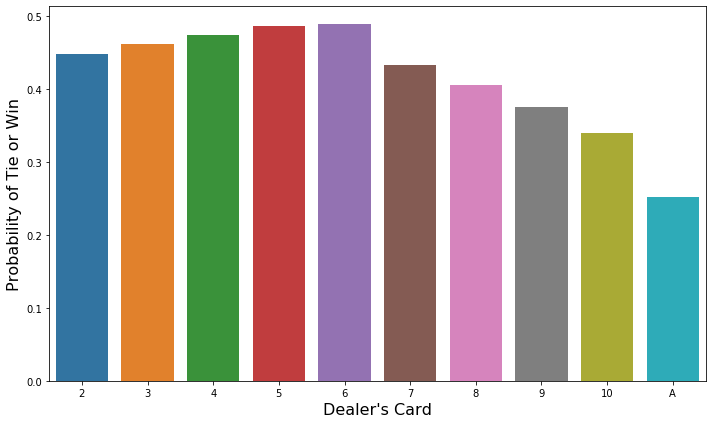

In [15]:
#From this we can see when the dealer has 6 in his card, he has the highest winning probability 48%
#when the dealer has A in his hand, the probiliby is the smallest
# bust 
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data.index, y=data.values)

ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.tight_layout()
plt.savefig(fname='dealer_card_probs', dpi=150)

In [16]:
data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
            model_df.groupby(by='player_total_initial').count()['lose'])

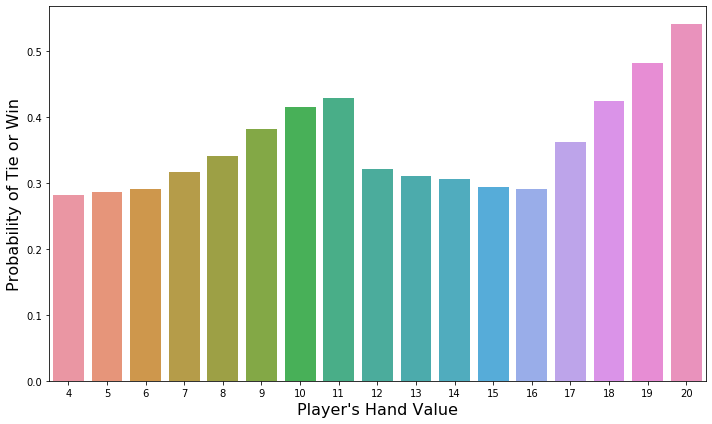

In [17]:
#when the player hand value is 19, 20 has the higher winning probality
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

plt.tight_layout()
plt.savefig(fname='player_hand_probs', dpi=150)

In [18]:
#when the player does not have ace the winner probability is higher?
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']

has_ace
0    0.642696
1    0.359947
Name: lose, dtype: float64

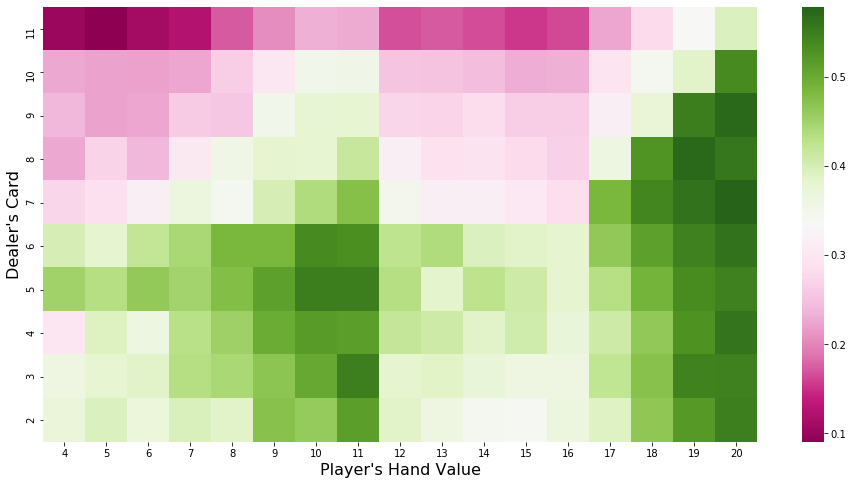

In [19]:
pivot_data = model_df[model_df['player_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_card_num'],
                              columns = ['player_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="PiYG");

ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Dealer's Card",fontsize=16)

plt.savefig(fname='heat_map_random', dpi=150)

In [20]:
stacks = 10000
players = 1
num_decks = 4

# a different strategy 
# Hit only when we know we will not bust hit when we know our hand value is not than 11 

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_results = []
player_live_action = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        action = 0

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Hit only when we know we will not bust
                    while sum_up(player_hands[player]) <= 11:
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                        if sum_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while sum_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if sum_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if sum_up(player_hands[player]) > sum_up(dealer_hand):
                    if sum_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_action.append(action)
    
model_df_naive = pd.DataFrame()
model_df_naive['dealer_card'] = dealer_card_feature
model_df_naive['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df_naive['player_result'] = [i[0] for i in player_results]
model_df_naive['hit?'] = player_live_action

lose = []
for i in model_df_naive['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_naive['lose'] = lose

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_naive['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_naive['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_naive['dealer_card_num'] = dealer_card_num

correct = []  #correct action 
for i, val in enumerate(model_df_naive['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df_naive['correct_action'] = correct

In [21]:
model_df_naive.head()

,dealer_card,player_total_initial,player_result,hit?,lose,has_ace,dealer_card_num,correct_action
0,10,13,-1.0,0,1,0,10,1
1,10,16,1.0,0,0,0,10,0
2,10,14,1.0,0,0,0,10,0
3,4,12,1.0,0,0,0,4,0
4,10,20,0.0,0,0,0,10,0


In [22]:
naive_win_possibility = 1 - (model_df_naive.sum()['lose'] /\
                  model_df_naive.count()['lose'])
print(naive_win_possibility)

0.47977185839896186


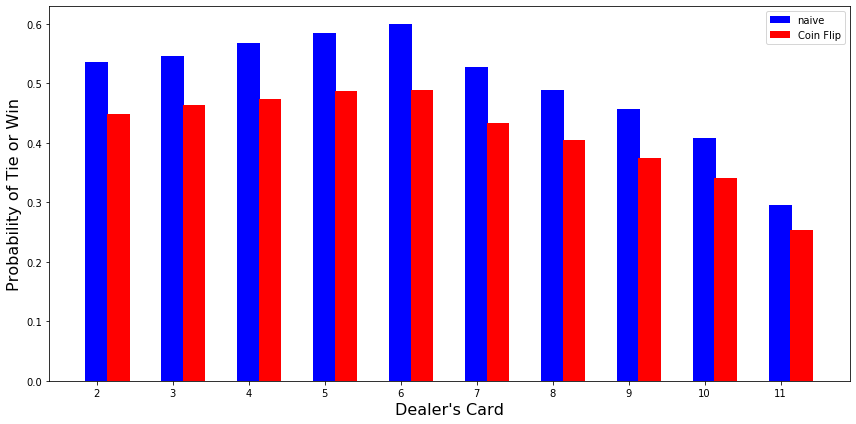

In [67]:
# As we can see use some strategy, we can see that the winning probability has increased
data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['naive'] = data_naive
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index, height=data['naive'].values, color='blue', width=0.3, label='naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_naive', dpi=150)

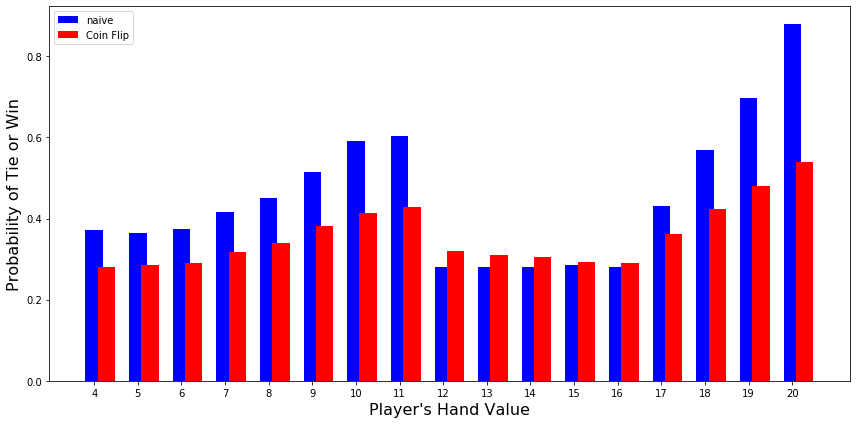

In [70]:
#winning probability has increased
data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_naive.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
data['naive'] = data_naive[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index, height=data['naive'].values, color='blue', width=0.4, label='naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.4, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_naive', dpi=150)

In [23]:
# Train a neural net to play blackjack
# use naive dataset to train the model
# Set up variables for neural net
feature_list = [i for i in model_df.columns if i not in ['dealer_card',
                                                         'player_result','lose',
                                                         'correct_action']]
print(feature_list)
train_X = np.array(model_df[feature_list])
train_Y = np.array(model_df['correct_action']).reshape(-1,1)  #is our target 
print(train_X)

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
[[13  1  0 10]
 [ 9  1  0  5]
 [21  0  1  2]
 ...
 [ 7  0  0  5]
 [12  0  0  6]
 [13  0  1  2]]


In [24]:
train_Y.shape

(357742, 1)

In [25]:
np.array(model_df['correct_action'])

array([1, 1, 0, ..., 1, 1, 0])

In [27]:
# Set up a neural net with 5 layers
# An epoch is one iteration over the entire input data
# In Keras, "dense" refers to a single layer, 
# "sequential" usually refers to an entire model
# Sequential refers to the way you build models in Keras 
# Build the neural network one layer at at time, in sequence: 
# Input layer, hidden layer 1, hidden layer 2, etc...output layer
# The Dense layer is a standard neural network layer that outputs
# and output arrays of shape (*, 16)  
# The main reason why we use sigmoid function is because it exists between (0 to 1)
# it is especially used for models where we have to predict the probability as an output.
# In neuronal networks tasked with binary classification, 
# sigmoid activation in the last (output) layer 
# and binary crossentropy (BCE) as the loss function are standard fare
# The batch size defines the number of samples that will be propagated through the network.

# A dense layer is a kind of hidden layer 
# where every node is connected to every other node in the next layer.

model = Sequential()
model.add(Dense(16))
model.add(Dense(32))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1, activation='sigmoid'))  #activation layer activation func 'sigmoid'
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.fit(train_X, train_Y, epochs=10, batch_size=32, verbose=1) 
pred_Y_train = model.predict(train_X)
actuals = train_Y[:,-1]

Epoch 1/10
357742/357742 [==============================] - 18s 50us/step - loss: 0.6235
Epoch 2/10
357742/357742 [==============================] - 15s 43us/step - loss: 0.6139
Epoch 3/10
357742/357742 [==============================] - 16s 44us/step - loss: 0.6131
Epoch 4/10
357742/357742 [==============================] - 16s 44us/step - loss: 0.6128
Epoch 5/10
357742/357742 [==============================] - 18s 50us/step - loss: 0.6125 0s - loss: 0
Epoch 6/10
357742/357742 [==============================] - 16s 46us/step - loss: 0.6124
Epoch 7/10
357742/357742 [==============================] - 16s 45us/step - loss: 0.6123
Epoch 8/10
357742/357742 [==============================] - 16s 46us/step - loss: 0.6122
Epoch 9/10
357742/357742 [==============================] - 16s 45us/step - loss: 0.6121
Epoch 10/10
357742/357742 [==============================] - 16s 45us/step - loss: 0.6120


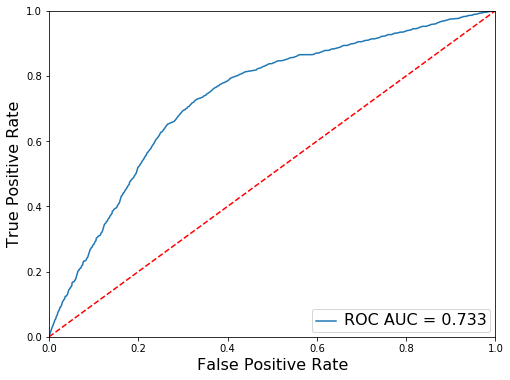

In [28]:
# a way to speculate the performance of the model
# Plot ROC Curve (Receiver Operating Characteristic)
# red line shows any true positive rate = false positive rate
# The ROC graph summarize all of the confusion metrics that each threshold produced.
# we want high true positive rate and false positive rate.
# AUC: area under curve
# It tells how much model is capable of distinguishing between classes. 
# The Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s
# precision is the proportion of positive results that were correctly classified
# When AUC is 0.733, 
#it means there is 73% chance that model 
# will be able to distinguish between positive class and negative class.
fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)

plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()

In [29]:
#train_X train_Y
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(16, 32, 8),max_iter=10000, verbose=10)


In [30]:
feature_list_test = [i for i in model_df.columns if i not in ['dealer_card',
                                                         'player_result','lose',
                                                         'correct_action']]
print(feature_list_test)
train_X_test = np.array(model_df[feature_list])
train_Y_test = np.array(model_df['correct_action']).reshape(-1,1)  #is our target 
print(train_X_test)

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
[[13  1  0 10]
 [ 9  1  0  5]
 [21  0  1  2]
 ...
 [ 7  0  0  5]
 [12  0  0  6]
 [13  0  1  2]]


In [31]:
mlp.fit(train_X, train_Y)

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.58997003
Iteration 2, loss = 0.56970275
Iteration 3, loss = 0.55794887
Iteration 4, loss = 0.55080432
Iteration 5, loss = 0.54788095
Iteration 6, loss = 0.54633538
Iteration 7, loss = 0.54552940
Iteration 8, loss = 0.54539137
Iteration 9, loss = 0.54490277
Iteration 10, loss = 0.54475002
Iteration 11, loss = 0.54460680
Iteration 12, loss = 0.54402448
Iteration 13, loss = 0.54416161
Iteration 14, loss = 0.54362334
Iteration 15, loss = 0.54366957
Iteration 16, loss = 0.54361680
Iteration 17, loss = 0.54329080
Iteration 18, loss = 0.54327207
Iteration 19, loss = 0.54285815
Iteration 20, loss = 0.54281205
Iteration 21, loss = 0.54265108
Iteration 22, loss = 0.54268545
Iteration 23, loss = 0.54231860
Iteration 24, loss = 0.54237194
Iteration 25, loss = 0.54228447
Iteration 26, loss = 0.54233196
Iteration 27, loss = 0.54223233
Iteration 28, loss = 0.54215341
Iteration 29, loss = 0.54208674
Iteration 30, loss = 0.54208488
Iteration 31, loss = 0.54203407
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(16, 32, 8), learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [32]:
print('Test accuracy', mlp.score(train_X_test,train_Y_test))

Test accuracy 0.7252656942712905


In [33]:
# and then based on that prediction, 
# use this model to predict the action 

def model_decision(model, player_sum, has_ace, dealer_card_num):
    input_array = np.array([player_sum, 0, has_ace, dealer_card_num]).reshape(1,-1)
    predict_correct = model.predict(input_array)
    if predict_correct >= 0.50:
        return 1
    else:
        return 0

In [34]:
# Play blackjack but use the neural net to make hit/stay decision

stacks = 10000
players = 1
num_decks = 4

card_types = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []

for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cards = generate_decks(num_decks, card_types)
    while len(dealer_cards) > 20:
        
        curr_player_results = np.zeros((1,players))
        
        dealer_hand = []
        player_hands = [[] for player in range(players)]
        live_total = []
        live_action = []

        # Deal FIRST card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        # Deal SECOND card
        for player, hand in enumerate(player_hands):
            player_hands[player].append(dealer_cards.pop(0))
        dealer_hand.append(dealer_cards.pop(0))
        
        # Record the player's live total after cards are dealt
        live_total.append(sum_up(player_hands[player]))
        action = 0

        # Dealer checks for 21
        if set(dealer_hand) == blackjack:
            for player in range(players):
                if set(player_hands[player]) != blackjack:
                    curr_player_results[0,player] = -1
                else:
                    curr_player_results[0,player] = 0
        else:
            for player in range(players):
                # Players check for 21
                if set(player_hands[player]) == blackjack:
                    curr_player_results[0,player] = 1
                else:
                    # Neural net decides whether to hit or stand
                    if 'A' in player_hands[player][0:2]:
                        ace_in_hand = 1
                    else:
                        ace_in_hand = 0
                    if dealer_hand[0] == 'A':
                        dealer_face_up_card = 11
                    else:
                        dealer_face_up_card = dealer_hand[0]
                    
                    while (model_decision(model, sum_up(player_hands[player]), 
                                          ace_in_hand, dealer_face_up_card) == 1) and (sum_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        action = 1
                        live_total.append(sum_up(player_hands[player]))
                        if sum_up(player_hands[player]) > 21:
                            curr_player_results[0,player] = -1
                            break
        
        # Dealer hits based on the rules
        while sum_up(dealer_hand) < 17:
            dealer_hand.append(dealer_cards.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if sum_up(dealer_hand) > 21:
            for player in range(players):
                if curr_player_results[0,player] != -1:
                    curr_player_results[0,player] = 1
        else:
            for player in range(players):
                if sum_up(player_hands[player]) > sum_up(dealer_hand):
                    if sum_up(player_hands[player]) <= 21:
                        curr_player_results[0,player] = 1
                elif sum_up(player_hands[player]) == sum_up(dealer_hand):
                    curr_player_results[0,player] = 0
                else:
                    curr_player_results[0,player] = -1
        
        # Track features
        dealer_card_feature.append(dealer_hand[0])
        player_card_feature.append(player_hands)
        player_results.append(list(curr_player_results[0]))
        player_live_total.append(live_total)
        player_live_action.append(action)

model_df_smart = pd.DataFrame()
model_df_smart['dealer_card'] = dealer_card_feature
model_df_smart['player_total_initial'] = [sum_up(i[0][0:2]) for i in player_card_feature]
model_df_smart['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_smart['has_ace'] = has_ace

dealer_card_num = []
for i in model_df_smart['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    else:
        dealer_card_num.append(i)
model_df_smart['dealer_card_num'] = dealer_card_num

model_df_smart['player_result'] = [i[0] for i in player_results]
lose = []
for i in model_df_smart['player_result']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_smart['lose'] = lose

In [35]:
model_df_smart

,dealer_card,player_total_initial,hit?,has_ace,dealer_card_num,player_result,lose
0,3,8,1,0,3,1.0,0
1,10,21,0,1,10,1.0,0
2,9,7,1,0,9,-1.0,1
3,10,12,1,0,10,1.0,0
4,9,9,1,0,9,0.0,0
...,...,...,...,...,...,...,...
332254,7,16,1,0,7,-1.0,1
332255,8,15,1,0,8,0.0,0
332256,10,6,0,0,10,-1.0,1
332257,10,20,0,0,10,0.0,0


In [36]:
smart_win_possibility = 1 - (model_df_smart.sum()['lose'] /\
                  model_df_smart.count()['lose'])
print(smart_win_possibility)

0.5094850703818407


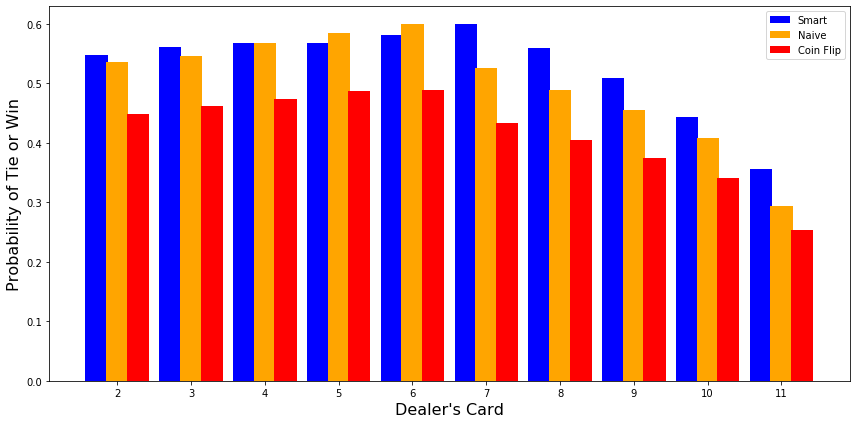

In [37]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['naive'] = data_naive
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.28, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
#plt.savefig(fname='dealer_card_probs_smart', dpi=150)

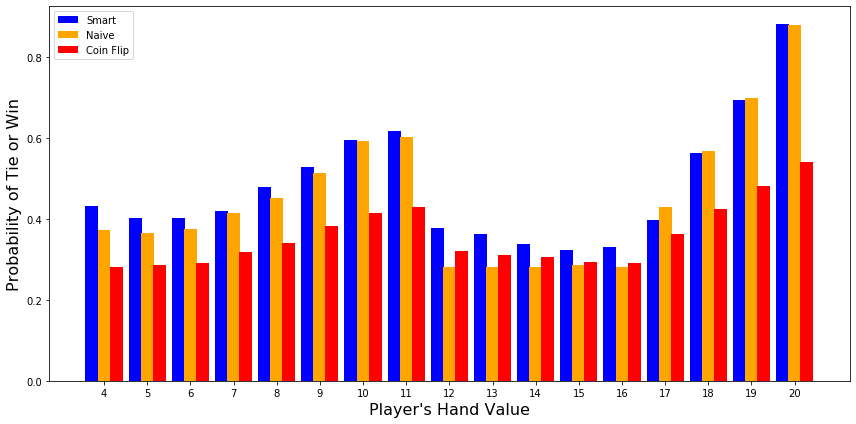

In [38]:
data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_smart.groupby(by='player_total_initial').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_naive.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart[:-1]
data['naive'] = data_naive[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.28, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_smart', dpi=150)

In [39]:
import pandas as pd
bjhands = pd.read_csv('~/Downloads/blackjack/blkjckhands.csv')
bjhands.head(20)

,Unnamed: 0,PlayerNo,card1,card2,card3,card4,card5,sumofcards,dealcard1,dealcard2,...,dealcard4,dealcard5,sumofdeal,blkjck,winloss,plybustbeat,dlbustbeat,plwinamt,dlwinamt,ply2cardsum
0,0,Player1,7,10,0,0,0,17,10,8,...,0,0,18,nowin,Loss,Beat,Dlwin,0,10,17
1,1,Player2,10,9,0,0,0,19,10,8,...,0,0,18,nowin,Win,Plwin,Beat,20,0,19
2,2,Player3,9,8,0,0,0,17,10,8,...,0,0,18,nowin,Loss,Beat,Dlwin,0,10,17
3,3,Player4,2,10,0,5,0,17,10,8,...,0,0,18,nowin,Loss,Beat,Dlwin,0,10,12
4,4,Player5,10,2,0,5,0,17,10,8,...,0,0,18,nowin,Loss,Beat,Dlwin,0,10,12
5,5,Player6,6,1,8,10,0,25,10,8,...,0,0,18,nowin,Loss,Bust,PlBust,0,10,7
6,0,Player1,10,4,0,0,0,14,4,4,...,10,0,23,nowin,Win,DlBust,Bust,20,0,14
7,1,Player2,3,10,0,0,0,13,4,4,...,10,0,23,nowin,Win,DlBust,Bust,20,0,13
8,2,Player3,10,2,0,0,0,12,4,4,...,10,0,23,nowin,Win,DlBust,Bust,20,0,12
9,3,Player4,9,6,0,0,0,15,4,4,...,10,0,23,nowin,Win,DlBust,Bust,20,0,15


In [41]:
invalid_data_index = bjhands.loc[(bjhands['card3'] == 0) & ((bjhands['card4'] != 0) | (bjhands['card5'] != 0))].index
invalid_data_index

Int64Index([     3,      4,     18,     19,     20,     23,     24,     28,
                29,     30,
            ...
            899960, 899961, 899963, 899964, 899968, 899969, 899976, 899977,
            899979, 899989],
           dtype='int64', length=226004)

In [42]:
bjhands.drop(invalid_data_index)

,PlayerNo,card1,card2,card3,card4,card5,sumofcards,dealcard1,dealcard2,dealcard3,dealcard4,dealcard5,sumofdeal,blkjck,winloss,plybustbeat,dlbustbeat,plwinamt,dlwinamt,ply2cardsum
0,Player1,7,10,0,0,0,17,10,8,0,0,0,18,nowin,Loss,Beat,Dlwin,0,10,17
1,Player2,10,9,0,0,0,19,10,8,0,0,0,18,nowin,Win,Plwin,Beat,20,0,19
2,Player3,9,8,0,0,0,17,10,8,0,0,0,18,nowin,Loss,Beat,Dlwin,0,10,17
5,Player6,6,1,8,10,0,25,10,8,0,0,0,18,nowin,Loss,Bust,PlBust,0,10,7
6,Player1,10,4,0,0,0,14,4,4,5,10,0,23,nowin,Win,DlBust,Bust,20,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,Player2,10,7,0,0,0,17,3,9,4,2,0,18,nowin,Loss,Beat,Dlwin,0,10,17
899996,Player3,6,1,10,0,0,17,3,9,4,2,0,18,nowin,Loss,Beat,Dlwin,0,10,7
899997,Player4,4,2,9,0,0,15,3,9,4,2,0,18,nowin,Loss,Beat,Dlwin,0,10,6
899998,Player5,9,10,0,0,0,19,3,9,4,2,0,18,nowin,Win,Plwin,Beat,20,0,19


In [43]:
bjhands.drop(bjhands.columns[0], axis=1, inplace=True)
nRow, nCol = bjhands.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 900000 rows and 19 columns


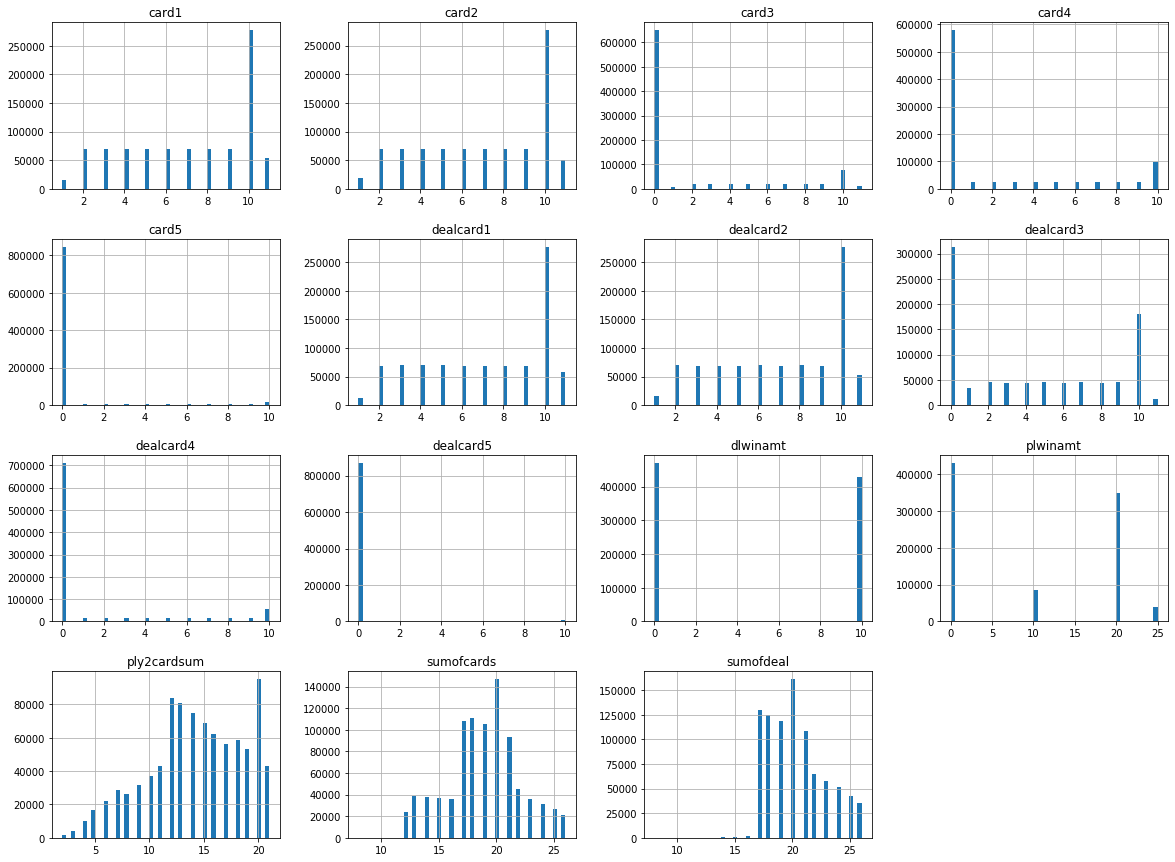

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

bjhands.hist(bins=50, figsize=(20,15))
plt.show()

In [45]:
#only keep need column
df = bjhands[['card1', 'card2', 'sumofcards', 'dealcard1', 'winloss']]
df

,card1,card2,sumofcards,dealcard1,winloss
0,7,10,17,10,Loss
1,10,9,19,10,Win
2,9,8,17,10,Loss
3,2,10,17,10,Loss
4,10,2,17,10,Loss
...,...,...,...,...,...
899995,10,7,17,3,Loss
899996,6,1,17,3,Loss
899997,4,2,15,3,Loss
899998,9,10,19,3,Win


In [46]:
df['player_total_initial'] = df['card1'] + df['card2']
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial
0,7,10,17,10,Loss,17
1,10,9,19,10,Win,19
2,9,8,17,10,Loss,17
3,2,10,17,10,Loss,12
4,10,2,17,10,Loss,12
...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17
899996,6,1,17,3,Loss,7
899997,4,2,15,3,Loss,6
899998,9,10,19,3,Win,19


In [47]:
# if player_total_initial == sumofcards hit = 0, else hit = 1
df['hit'] = df.apply(lambda x : 0 if x['player_total_initial'] == x['sumofcards'] else 1, axis=1)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial,hit
0,7,10,17,10,Loss,17,0
1,10,9,19,10,Win,19,0
2,9,8,17,10,Loss,17,0
3,2,10,17,10,Loss,12,1
4,10,2,17,10,Loss,12,1
...,...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17,0
899996,6,1,17,3,Loss,7,1
899997,4,2,15,3,Loss,6,1
899998,9,10,19,3,Win,19,0


In [48]:
# Y: win 1, push 0, nowin -1
df['player_result'] = df.apply(lambda x : -1 if x['winloss'] == 'Loss' else (1 if x['winloss'] == 'Win' else 0), axis=1)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial,hit,player_result
0,7,10,17,10,Loss,17,0,-1
1,10,9,19,10,Win,19,0,1
2,9,8,17,10,Loss,17,0,-1
3,2,10,17,10,Loss,12,1,-1
4,10,2,17,10,Loss,12,1,-1
...,...,...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17,0,-1
899996,6,1,17,3,Loss,7,1,-1
899997,4,2,15,3,Loss,6,1,-1
899998,9,10,19,3,Win,19,0,1


In [49]:
#has_ace: card1 == 1 or card1 == 11 or card2 == 1 or card2 == 11?
df['has_ace'] = df.apply(lambda x : 1 if x['card1'] == 1 or x['card1'] == 11 or x['card2'] == 1 or x['card2'] == 11 else 0, axis=1)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial,hit,player_result,has_ace
0,7,10,17,10,Loss,17,0,-1,0
1,10,9,19,10,Win,19,0,1,0
2,9,8,17,10,Loss,17,0,-1,0
3,2,10,17,10,Loss,12,1,-1,0
4,10,2,17,10,Loss,12,1,-1,0
...,...,...,...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17,0,-1,0
899996,6,1,17,3,Loss,7,1,-1,1
899997,4,2,15,3,Loss,6,1,-1,0
899998,9,10,19,3,Win,19,0,1,0


In [50]:

df['lose'] = df.apply(lambda x : 1 if x['player_result'] == -1 else 0, axis=1)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial,hit,player_result,has_ace,lose
0,7,10,17,10,Loss,17,0,-1,0,1
1,10,9,19,10,Win,19,0,1,0,0
2,9,8,17,10,Loss,17,0,-1,0,1
3,2,10,17,10,Loss,12,1,-1,0,1
4,10,2,17,10,Loss,12,1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17,0,-1,0,1
899996,6,1,17,3,Loss,7,1,-1,1,1
899997,4,2,15,3,Loss,6,1,-1,0,1
899998,9,10,19,3,Win,19,0,1,0,0


In [51]:
# correct_hit: if lose == 1     if hit -> not hit, not hit->hit
# else: if lose == 0 hit->hit, not hit-> not hit
df['correct_action'] = df.apply(lambda x : 1 - x['hit'] if x['lose'] == 1 else x['lose'], axis=1)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,card1,card2,sumofcards,dealcard1,winloss,player_total_initial,hit,player_result,has_ace,lose,correct_action
0,7,10,17,10,Loss,17,0,-1,0,1,1
1,10,9,19,10,Win,19,0,1,0,0,0
2,9,8,17,10,Loss,17,0,-1,0,1,1
3,2,10,17,10,Loss,12,1,-1,0,1,0
4,10,2,17,10,Loss,12,1,-1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
899995,10,7,17,3,Loss,17,0,-1,0,1,1
899996,6,1,17,3,Loss,7,1,-1,1,1,0
899997,4,2,15,3,Loss,6,1,-1,0,1,0
899998,9,10,19,3,Win,19,0,1,0,0,0


In [52]:
df = df[['dealcard1', 'player_total_initial', 'hit', 'player_result', 'has_ace', 'lose', 'correct_action']]
df.head()

,dealcard1,player_total_initial,hit,player_result,has_ace,lose,correct_action
0,10,17,0,-1,0,1,1
1,10,19,0,1,0,0,0
2,10,17,0,-1,0,1,1
3,10,12,1,-1,0,1,0
4,10,12,1,-1,0,1,0


In [53]:
df.rename(columns = {'dealcard1':'dealer_card_num'}, inplace = True) 
df

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,dealer_card_num,player_total_initial,hit,player_result,has_ace,lose,correct_action
0,10,17,0,-1,0,1,1
1,10,19,0,1,0,0,0
2,10,17,0,-1,0,1,1
3,10,12,1,-1,0,1,0
4,10,12,1,-1,0,1,0
...,...,...,...,...,...,...,...
899995,3,17,0,-1,0,1,1
899996,3,7,1,-1,1,1,0
899997,3,6,1,-1,0,1,0
899998,3,19,0,1,0,0,0


In [54]:
df_win_possibility = 1 - (df.sum()['lose'] /\
                  df.count()['lose'])
print(df_win_possibility)

0.5224211111111111


Text(0, 0.5, 'Probability of Tie or Win')

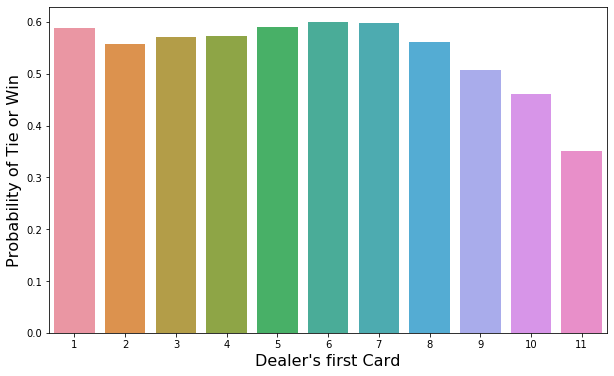

In [55]:
data = 1 - (df.groupby(by='dealer_card_num').sum()['lose'] /\
            df.groupby(by='dealer_card_num').count()['lose'])
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.barplot(x=data.index, 
                 y=data.values)
ax.set_xlabel("Dealer's first Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

Text(0, 0.5, 'Probability of Tie or Win')

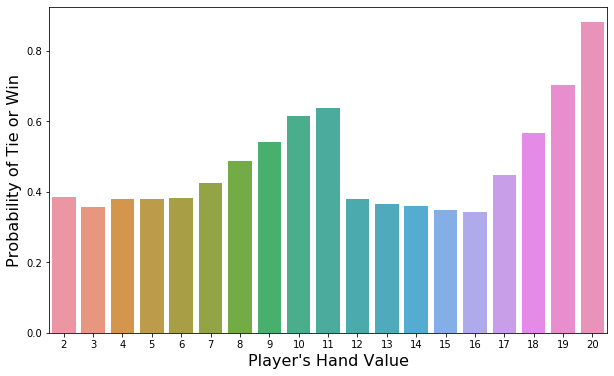

In [56]:
data = 1 - (df.groupby(by='player_total_initial').sum()['lose'] /\
            df.groupby(by='player_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)

In [57]:
df.groupby(by='has_ace').sum()['lose'] / df.groupby(by='has_ace').count()['lose']

has_ace
0    0.509865
1    0.292180
Name: lose, dtype: float64

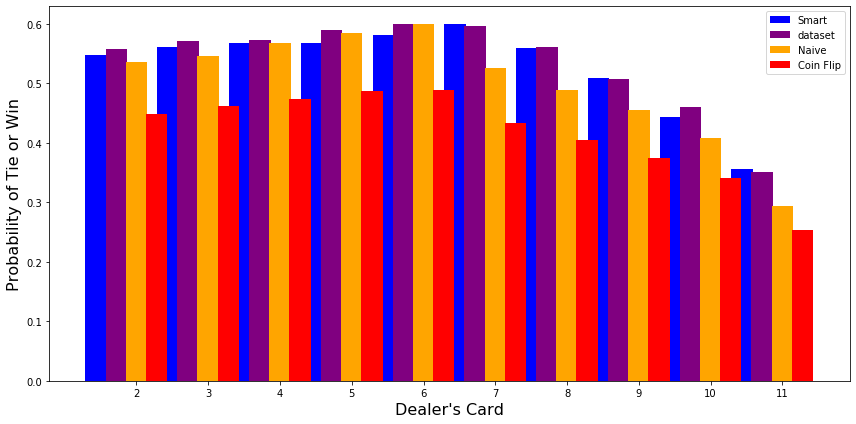

In [58]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_card_num').count()['lose'])
data_dataset = 1 - (df.groupby(by='dealer_card_num').sum()['lose'] /\
                   df.groupby(by='dealer_card_num').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] /\
                  model_df_naive.groupby(by='dealer_card_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_card_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_card_num').count()['lose'])



data = pd.DataFrame()
data['smart'] = data_smart
data['dataset'] = data_dataset
data['naive'] = data_naive
data['random'] = data_random

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.56, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index-0.28, height=data['dataset'].values, color='purple', width=0.3, label='dataset')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_card_probs_smart', dpi=150)


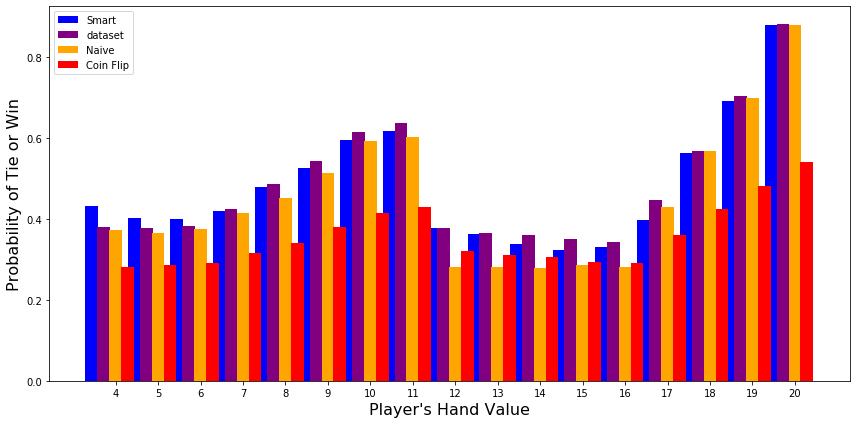

In [59]:

data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_smart.groupby(by='player_total_initial').count()['lose'])
data_dataset = 1 - (df.groupby(by='player_total_initial').sum()['lose'] /\
                  df.groupby(by='player_total_initial').count()['lose'])
data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] /\
                  model_df_naive.groupby(by='player_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] /\
                   model_df.groupby(by='player_total_initial').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart[:-1]
data['dataset'] = data_dataset[:-1]
data['naive'] = data_naive[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.56, height=data['smart'].values, color='blue', width=0.3, label='Smart')
ax.bar(x=data.index-0.28, height=data['dataset'].values, color='purple', width=0.3, label='dataset')
ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
ax.bar(x=data.index+0.28, height=data['random'].values, color='red', width=0.3, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=16)
ax.set_ylabel("Probability of Tie or Win",fontsize=16)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='player_hand_probs_smart', dpi=150)

In [60]:
# Train a neural net to play blackjack
# use dataset to train the model
# Set up variables for neural net
feature_list_dataset = [i for i in df.columns if i not in ['dealer_card',
                                                         'player_result','lose',
                                                         'correct_action']]
print(feature_list_dataset)
train_X_dataset = np.array(df[feature_list_dataset])
train_Y_dataset = np.array(df['correct_action']).reshape(-1,1)  #is our target 
print(train_X_dataset)

['dealer_card_num', 'player_total_initial', 'hit', 'has_ace']
[[10 17  0  0]
 [10 19  0  0]
 [10 17  0  0]
 ...
 [ 3  6  1  0]
 [ 3 19  0  0]
 [ 3 15  0  0]]


In [61]:
print(train_Y_dataset)

[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


In [63]:
model_dataset = Sequential()
model.add(Dense(16))
model.add(Dense(32))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(16))
model_dataset.add(Dense(1, activation='sigmoid'))  #activation layer activation func 'sigmoid'
model_dataset.compile(loss='binary_crossentropy', optimizer='sgd')
model_dataset.fit(train_X_dataset, train_Y_dataset, epochs=20, batch_size=256, verbose=1) 
pred_Y_train_dataset = model.predict(train_X_dataset)
actuals_dataset = train_Y_dataset[:,-1]

Epoch 1/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.3832
Epoch 2/20
900000/900000 [==============================] - 4s 5us/step - loss: 0.3276
Epoch 3/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.3107
Epoch 4/20
900000/900000 [==============================] - 7s 8us/step - loss: 0.3019
Epoch 5/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.2964
Epoch 6/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.2923
Epoch 7/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.2891
Epoch 8/20
900000/900000 [==============================] - 8s 9us/step - loss: 0.2864
Epoch 9/20
900000/900000 [==============================] - 6s 7us/step - loss: 0.2842
Epoch 10/20
900000/900000 [==============================] - 6s 6us/step - loss: 0.2822
Epoch 11/20
900000/900000 [==============================] - 5s 5us/step - loss: 0.2805
Epoch 12/20
900000/900000 [==============

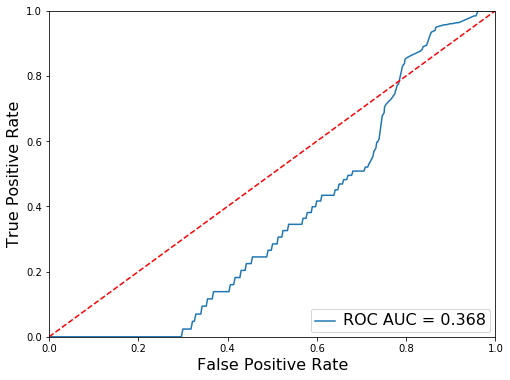

In [64]:
fpr, tpr, threshold = metrics.roc_curve(actuals_dataset,pred_Y_train_dataset)
roc_auc = metrics.auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)

plt.savefig(fname='roc_curve_blackjack', dpi=150)
plt.show()